<a href="https://colab.research.google.com/github/descandon88/Economics-Complexity/blob/main/1_netviz_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Visualize the space as a network

In this section, we will practice how to visualize the X-spaces with tradtional network-based method.

The sections are organized according to our viz-pipeline:
- Data collection and metric calculation (load previous results)
- Extract the informative part of relation: mst + high proximity
- Layout generation: force-layout
- cluster generation: community detection
- Aesthetic mapping: desired property -> visual elements
  - Whole network
  - Portfolio




Colab already provided basic packages needed for the task, such as numpy,scipy,pandas,networkx and matplotlib. Here we install two more packages: fa2 for network layout generation and python-louvain for community detection.

In [ ]:
!pip install fa2 python-louvain

In [ ]:
# load the basic packages
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Data collection and metric calculation (load previous results)

In this part, we need to get a proximity matrix or dataframe as the input of following steps. If you are doing your own research on some kind of spaces, you need to clean and transform your raw data, and assess the relatedness with a similarity or distance metric.

Here we will use a pre-calculated proximity dataframe from the Atlas of Economic complexity. You can get this dataframe by following Matte's tutorial on Monday, or use the py-ecomplexity package.

In [ ]:
# load the precalculated proximity dataframe
# you could load your own saved proximity data
proxurl = 'http://intl-atlas-downloads.s3.amazonaws.com/atlas_2_16_6/hs92_proximities.csv'
proxdf = pd.read_csv(proxurl,dtype={'commoditycode_1':str,'commoditycode_2':str,'proximity':float})
proxdf.head()

,commoditycode_1,commoditycode_2,proximity
0,0101,0101,0.000000
1,0101,0102,0.277778
2,0101,0103,0.352941
3,0101,0104,0.260870
4,0101,0105,0.296296


Let's first examine the distribution of proximity metric, which helps us decide in extracting the informative parts.

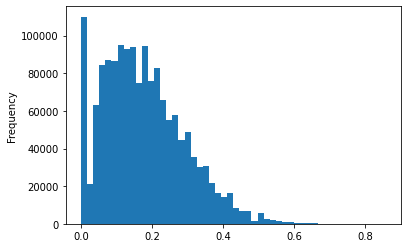

In [ ]:
proxdf.proximity.plot.hist(bins=50)

We observed that proximity is right-skewed. There are a few observations in the right tail with high proximity, which is good: we can cover the informative part without introducing many links.

Load the names of hs code so that we could use for annotation and analysis.

In [ ]:
hsurl = 'http://intl-atlas-downloads.s3.amazonaws.com/17.0/hs_product.zip'
hsdf = pd.read_csv(hsurl,compression='zip',dtype='str')
hsdf.head()

,product_id,hs_product_code,hs_product_name_short_en
0,0,0,Textiles
1,1,1,Agriculture
2,2,2,Stone
3,3,3,Minerals
4,4,4,Metals


Let's only keep the product names used in the calculation of proximity:

In [ ]:
hsdf.hs_product_code.nunique(),proxdf.commoditycode_1.nunique()

(6396, 1240)

In [ ]:
nodedf = hsdf[hsdf.hs_product_code.isin(proxdf.commoditycode_1)][['hs_product_code','hs_product_name_short_en']].sort_values('hs_product_code').reset_index(drop=True)
nodedf.head()

,hs_product_code,hs_product_name_short_en
0,0101,Horses
1,0102,Bovine
2,0103,Swine
3,0104,Sheep
4,0105,Fowl


### (Optional) visualize the raw proximity matrix

If your data is a proximity dataframe, you could transform it into a proxmity matrix using the pandas "pivot" function. The matrix format is sometimes faster for density calculation and other tasks. On the other hand, you could also get a proximity dataframe using pandas "melt" or other functions.

In [ ]:
proxmat = proxdf.pivot(index='commoditycode_1', columns='commoditycode_2',values='proximity').to_numpy()
proxmat.shape

(1240, 1240)

You could visualize the proximity matrix directly using a heatmap. The natural sorting of product codes usually exhibits a block structure.

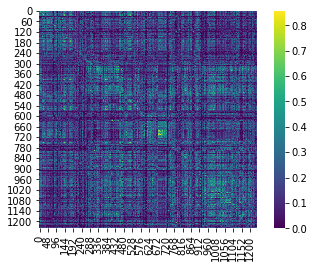

In [ ]:
sns.heatmap(proxmat,cmap='viridis',square=True)

## Create graph and extract the backbone

Given the proximity dataframe or matrix, we could convert them into networkx object. By default, it will create an undirected network. We set the "edge_attr" as **True**, so every other columns in the dataframe are loaded as edge attributes:

In [ ]:
fullgraph = nx.from_pandas_edgelist(proxdf,source='commoditycode_1',target='commoditycode_2',edge_attr=True)
fullgraph.number_of_nodes(),fullgraph.number_of_edges()

(1240, 769420)

Networkx provides the function to generate a minimum/maximum spanning tree, we will generate this using proximity values as the basic skeleton, which makes sure every nodes are connected.

In [ ]:
mst = nx.maximum_spanning_tree(fullgraph,weight='proximity')
mst.number_of_edges()

1239

# Exercise 1

Try a different threshold (other than 0.55) to create the network. Below is the previous code.


```
vizgraph = mst.copy()
vizgraph.add_edges_from([(u,v,d) for u,v,d in fullgraph.edges(data=True) if d['proximity']>0.55])
vizgraph.number_of_edges()
```



In [ ]:
## put your code below
vizgraph = mst.copy()
vizgraph.add_edges_from([(u,v,d) for u,v,d in fullgraph.edges(data=True) if d['proximity']>0.5])
vizgraph.number_of_edges()

5551

In [ ]:
nx.density(vizgraph)

0.00722617094951704

## Generate layout of the nodes

Before we jump to the visualization of full network, let's check how the mst skeleton looks.

Here we use the Kamada-Kawai algorithm to generate a layout, which generally works well for smaller networks:

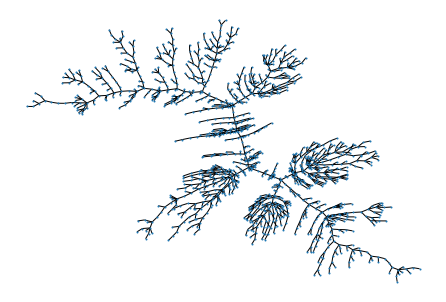

In [ ]:
position = nx.kamada_kawai_layout(mst)
nx.draw(mst,pos=position,node_size=1)

The result already revealed some branches and clusters, we could use this layout as an initial position and speed up the generation of `vizgraph` layout.

In this step, you would probably want to explore different layout algorithms, tune their parameters, and plot them until you get a satisfying position. Sometimes, it may require some manual adjustments before you finalize the layout.

# Exercise 2

Use another layout algorithm, such as the `sprint_layout` in networkx, and tune the parameters to generate a new usable layout.

The available layout algorithms and their documents are here: https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout

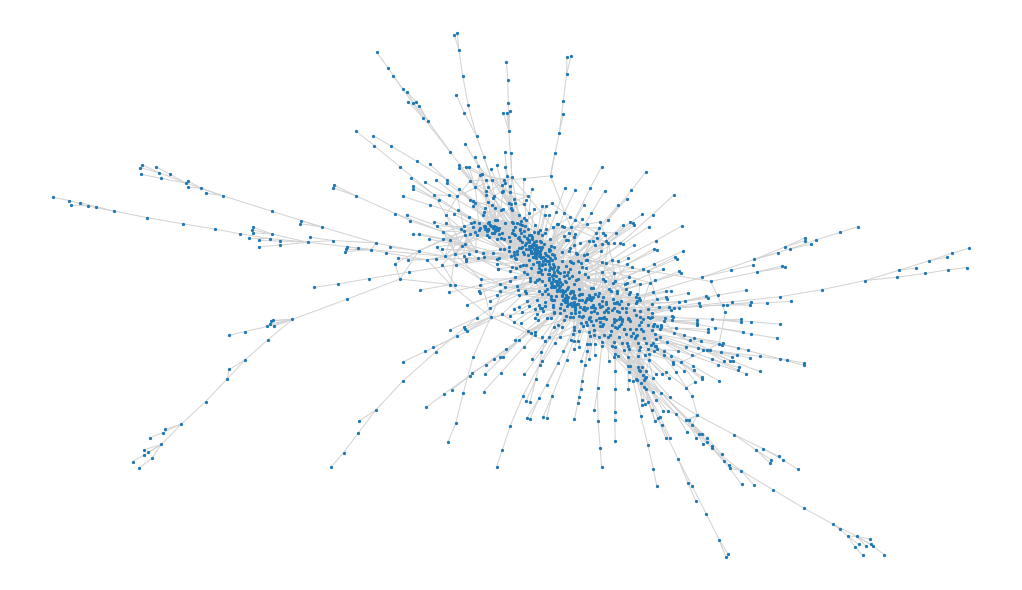

In [ ]:
## put your code below
position2 = nx.spring_layout(G=vizgraph, pos=position)
plt.figure(figsize=(14,8))
nx.draw(vizgraph,pos=position2,node_size=5,edge_color='lightgrey')

The position output is a dictionary, we could create a dataframe and merge it with the nodedf for future use.

In [ ]:
nodedf = nodedf.merge(
    pd.DataFrame.from_dict(position2,orient='index',columns=['x','y']),
    how='left',
    left_on='hs_product_code',
    right_index=True
)
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y
0,0101,Horses,0.110120,0.045237
1,0102,Bovine,-0.044223,0.128434
2,0103,Swine,0.086383,0.046852
3,0104,Sheep,-0.106813,0.364285
4,0105,Fowl,-0.016853,0.084215


## Community detection

We would like to extract more meso-scale structural information out of this network representation, one option is to extract the community structure that reveal the block structure we saw in matrix plot.

There are a number of community detection algorithms. The Louvain algorithm is one of the most widely used solution, and the python implementation is here: https://python-louvain.readthedocs.io/en/latest/api.html

In [ ]:
import community as community_louvain
partition = community_louvain.best_partition(vizgraph,weight='proximity',resolution=1,random_state=42)
max(partition.values()) + 1

29

The `partition` object is a dictionary that sequentially maps each nodes to the community id. We could also merge it to the nodedf dataframe for further analysis.

In [ ]:
nodedf = nodedf.merge(
    pd.DataFrame.from_dict(partition,orient='index',columns=['communityid']),
    how='left',
    left_on='hs_product_code',
    right_index=True
)
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y,communityid
0,0101,Horses,0.110120,0.045237,0
1,0102,Bovine,-0.044223,0.128434,1
2,0103,Swine,0.086383,0.046852,2
3,0104,Sheep,-0.106813,0.364285,3
4,0105,Fowl,-0.016853,0.084215,1


Using pandas, we could check the size of each communities:

In [ ]:
nodedf.communityid.value_counts()

0     236
2     179
1     173
14    149
8     127
6      69
7      43
3      41
11     31
4      30
17     22
15     22
9      20
10     14
24     13
25     12
21      9
12      6
27      5
19      5
20      5
23      4
13      4
18      4
22      4
26      4
16      3
5       3
28      3
Name: communityid, dtype: int64

For each community, we could check the included products to understand its meaning.

For example, community 6 is a cluster of garments and textile products

In [ ]:
nodedf.query('communityid == 6').sample(15)

,hs_product_code,hs_product_name_short_en,x,y,communityid
856,7317,Nails and similar articles of iron or steel,-0.121253,0.069096,6
719,6306,"Tents, tarpaulins, etc.",-0.287413,0.146925,6
598,5204,Cotton sewing thread,-0.168128,0.177984,6
198,2401,Unmanufactured tobacco,-0.122662,0.185052,6
31,0409,Honey,-0.192837,0.160341,6
717,6304,Other furnishing articles,-0.228630,0.133207,6
705,6209,Babies' garments,-0.141071,0.155768,6
682,6103,"Men's suits, knit",-0.147211,0.167760,6
694,6115,"Socks, stockings, etc., knit",-0.107225,0.134027,6
601,5207,Cotton yarn for retail sale,-0.186655,0.167255,6


Rearrange the rows and columns in matrix plot, we see a clearer block structure

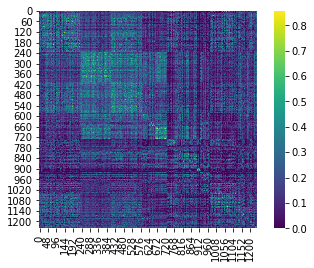

In [ ]:
idx = np.argsort(nodedf.communityid)
proxmat2 = proxmat[:,idx][idx]
sns.heatmap(proxmat2,cmap='viridis',square=True)

## Mapping properties to aesthetic elements

Once we have fixed the position of nodes in the network, the aesthetic elements we could use are mainy the color and size of the nodes. Different shapes of the nodes are not very distinguishable with >1000 nodes, and labels are only usable to annotate few nodes/sectors/communities.

In this section, we will use a saved output from running the py-ecomplexity package on 2015 HS 4-digit trade data:

In [ ]:
df_ec = pd.read_parquet('https://github.com/complexly/summerschool_viz/raw/main/df_ec.parquet')
df_ec.head()

,location_code,hs_product_code,export_value,year,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca,location_name_short_en,hs_product_name_short_en
0,ABW,0101,0.0,2015,25,20,0,0.214456,0.388663,0.026560,-0.760492,0.311309,0.000000,Aruba,"Horses, asses, mules and hinnies; live"
1,ABW,0102,0.0,2015,25,44,0,0.214456,-0.223360,0.029281,-0.760492,-0.031652,0.000000,Aruba,Bovine animals; live
2,ABW,0103,0.0,2015,25,19,0,0.214456,1.915566,0.020574,-0.760492,0.683068,0.000000,Aruba,Swine; live
3,ABW,0104,0.0,2015,25,24,0,0.214456,-2.384068,0.020903,-0.760492,-0.198515,0.000000,Aruba,Sheep and goats; live
4,ABW,0105,13182.0,2015,25,31,0,0.214456,0.804562,0.025347,-0.760492,0.462749,0.039424,Aruba,"Poultry; live, fowls of the species gallus dom..."


### Color

The color of the nodes are usually used to indicate different categories, such as 2-digit sectors or the communities we discovered above.

A meaningful color map usually require some manual design, such as using brown to represent mining activities and products. Here we would just assign a color to each commmunity from the rainbow color pallette, without further improvement.

In [ ]:
from matplotlib import colors
# use the gist_rainbow colormap
cm = plt.get_cmap('gist_rainbow')
# map each communityid to a color, the output is an rgba array for each node 
colorarray = cm([x/nodedf.communityid.nunique() for x in nodedf.communityid])
# convert the rgba array into a hex string, and store the result into the nodedf dataframe
nodedf['color'] = np.apply_along_axis(colors.to_hex, 1, colorarray)
nodedf.sample(5)

,hs_product_code,hs_product_name_short_en,x,y,communityid,color
42,0510,Animal products used in pharmaceuticals,0.146943,0.175669,4,#ff9400
765,6907,Unglazed ceramic flags and pavers,0.258656,-0.133761,17,#00fcff
833,7223,Wire of stainless steel,0.081276,-0.086064,0,#ff0029
593,5112,Woven fabrics of combed wool,0.106168,0.079756,8,#adff00
287,2821,Iron oxides and hydroxides,0.059783,-0.183576,0,#ff0029


Now let's use this color to make a plot. The `node_color` parameter accepts rgba array or hex string for each nodes, which we generated above and already in the correct order.

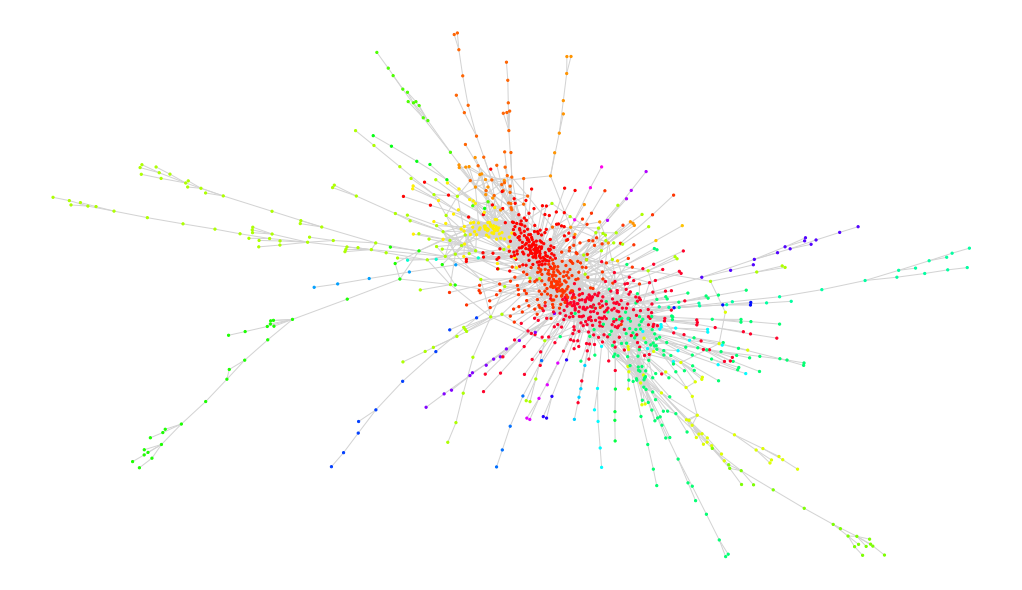

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,pos=position2,node_size=5,node_color=nodedf.color,edge_color='lightgrey')

### Size

# Exercise 3

Use the node size to represent the logged total trade volume of a product, which is the "log_export_value" columns in the `nodedf` dataframe.

In [ ]:
nodedf = nodedf.merge(
    df_ec.groupby('hs_product_code')['export_value'].sum(),
    how='left',
    on='hs_product_code'
)
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y,communityid,color,export_value
0,0101,Horses,0.110120,0.045237,0,#ff0029,2.589017e+09
1,0102,Bovine,-0.044223,0.128434,1,#ff0200,8.387313e+09
2,0103,Swine,0.086383,0.046852,2,#ff3300,3.814115e+09
3,0104,Sheep,-0.106813,0.364285,3,#ff6300,2.089496e+09
4,0105,Fowl,-0.016853,0.084215,1,#ff0200,2.826775e+09


In [ ]:
nodedf['log_export_value'] = np.log(nodedf['export_value'])
nodedf.log_export_value.describe()

count    1239.000000
mean       21.619698
std         2.148929
min         9.214332
25%        20.499635
50%        21.820813
75%        22.989614
max        27.380642
Name: log_export_value, dtype: float64

In [ ]:
## put your code below
nodedf['nodesize'] = 1 + (nodedf.log_export_value - nodedf.log_export_value.min())/(nodedf.log_export_value.max() - nodedf.log_export_value.min()) * 99

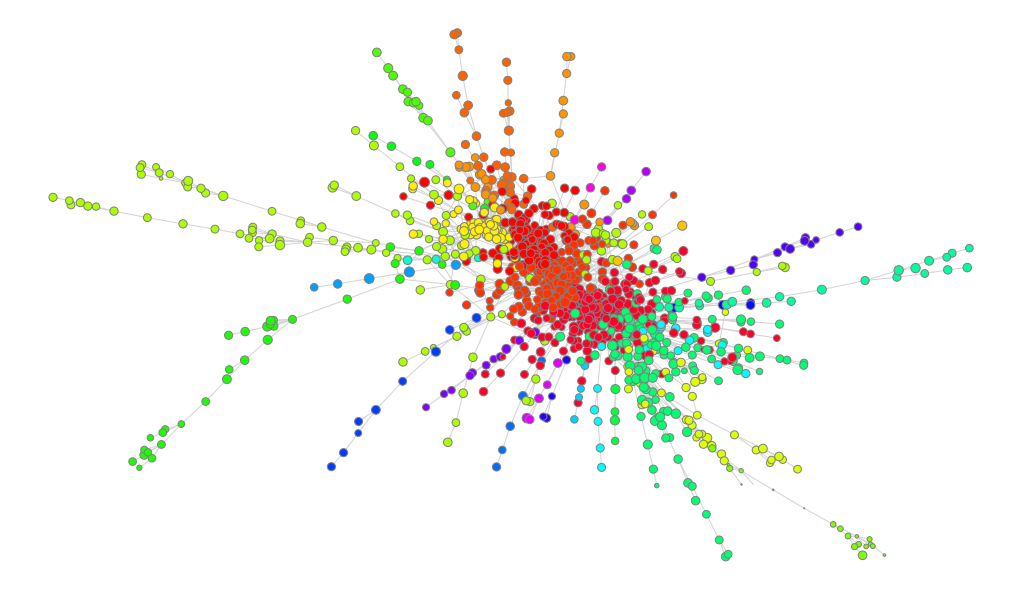

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=nodedf.color,
        edge_color='lightgrey',
        edgecolors='grey')

### Annotation

Sometimes we would like to add some annotations to the product space visualization. Here we will add the communityid to the center of each community.

In [ ]:
df_annotation = nodedf.groupby('communityid')[['x','y']].mean().reset_index()
df_annotation.head()

,communityid,x,y
0,0,0.089741,-0.072174
1,1,-0.060469,0.132124
2,2,-0.002309,0.029673
3,3,-0.123053,0.370951
4,4,-0.046650,0.310017


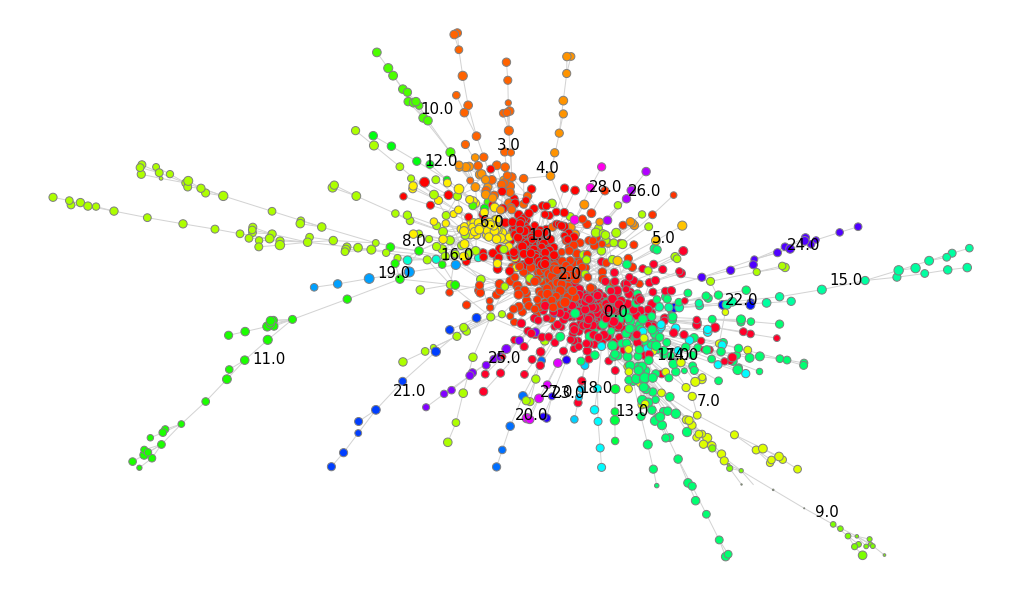

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=nodedf.color,
        edge_color='lightgrey',
        edgecolors='grey')
for i, point in df_annotation.iterrows():
        plt.annotate(point['communityid'],(point['x'], point['y']),fontsize=15)

### Region specific plot

# Exercise 4

Plot the product highlighting where Ukraine (location code: UKR) has comparative advantage.

In [ ]:
# put your code below
df_UKR = df_ec[(df_ec.location_code == "UKR") & (df_ec.mcp>0)][['hs_product_code','mcp']]
df_UKR.head()

,hs_product_code,mcp
271629,0102,1
271633,0106,1
271635,0202,1
271640,0207,1
271642,0209,1


In [ ]:
ukr_color = nodedf.color.where(
    nodedf.hs_product_code.isin(df_UKR.hs_product_code),
    'lightgrey'
    )

Plot the result for Ukraine

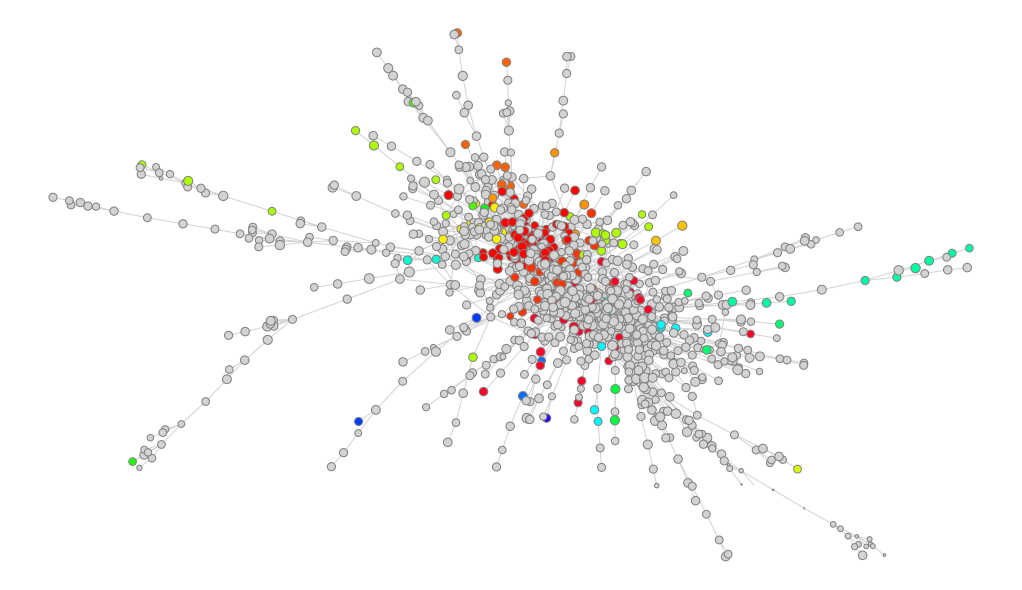

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=ukr_color,
        edge_color='lightgrey',
        edgecolors='grey')